# 画像分類例題

## ライブラリインポート

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
from torch import optim
np.set_printoptions(suppress=True, precision=1,linewidth=280)

## データセット取得

In [2]:
train_data = torchvision.datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = transforms.ToTensor(), 
    download = True,            
)

train_data_loader = torch.utils.data.DataLoader(train_data,
                                                batch_size=100,
                                                shuffle=True)


## データの中身を確認

images.size() = torch.Size([100, 1, 28, 28]) , [データ番号、チャンネル（白黒画像なので輝度のみ）、行、列]
labels[1] = tensor(8) , ラベルデータ
images[1][0].numpy() =
 [[0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.2 0.6 1.  1.  0.9 0.6 0.6 0.6 0.3 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.5 0.9 1.  0.7 0.9 1.  1.  1.  1.  

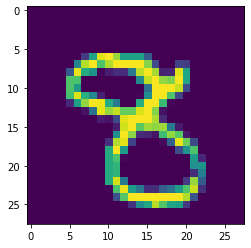

In [3]:
train_data_iter = iter(train_data_loader)
images, labels = train_data_iter.next()

i=1
print("images.size() =",images.size(),", [データ番号、チャンネル（白黒画像なので輝度のみ）、行、列]")
print("labels["+str(i)+"] =",labels[i],", ラベルデータ")
print("images["+str(i)+"][0].numpy() =\n",images[i][0].numpy(),", 輝度データをそのまま表示")
plt.imshow(images[i][0]) # 


## CNN

In [4]:
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = torch.nn.Sequential(         
                         torch.nn.Conv2d(
                             in_channels=1,              
                             out_channels=16,            
                             kernel_size=5,              
                             stride=1,                   
                             padding=2,                  
                         ),                              
                         torch.nn.ReLU(),                      
                         torch.nn.MaxPool2d(kernel_size=2),    
                      )
        self.conv2 = torch.nn.Sequential(
                         torch.nn.Conv2d(
                             in_channels=16, 
                             out_channels=32, 
                             kernel_size=5, 
                             stride=1, 
                             padding=2
                         ),
                         torch.nn.ReLU(),                      
                         torch.nn.MaxPool2d(2),                
                     )
        self.fc = torch.nn.Linear(32 * 7 * 7, 10)
        self.out = torch.nn.Softmax()
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)       
        output = self.out(self.fc(x))
        return output

In [5]:
cnn = CNN()
print("CNN =",cnn)

CNN = CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=1568, out_features=10, bias=True)
  (out): Softmax(dim=None)
)


## クロスエントロピー損失

In [6]:
loss_func = torch.nn.CrossEntropyLoss()
# 第一引数：モデルによる予測、第二引数：正解ラベルデータ、とする。
# 今回の実装では、スライドの説明と一貫性を持たせるため、ラベル選択確率をcnnモデルで出力して第一引数に突っ込んでいる。

# （発展的内容コメント）このtorch.nn.CrossEntropyLoss()関数は、第一引数に対してsoftmaxを適用するような実装になっているので、
# 規格化していないラベル選択確率の対数を第一引数に突っ込んでもOK（たぶん、その方が実装としては効率的）
# 詳しくは、https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.htmlを見る事

## 確率的勾配降下法

In [7]:
optimizer = optim.SGD(cnn.parameters(), lr = 0.9)   

## 分類器の訓練

In [8]:
for epoch in range(1):
    running_loss = 0.0
    for data in train_data_loader:
        images, labels = data
        
        optimizer.zero_grad()

        outputs = cnn(images)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    print("running_loss =",running_loss)


C:\Users\toru.hishinuma\AppData\Local\Temp\ipykernel_5440\3992617524.py:33: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.out(self.fc(x))


running_loss = 1035.8203469514847


## 訓練した分類器の予測を確認

labels[2] = tensor(7) , ラベルデータ
outputs[2] = tensor([1.6123e-12, 2.4494e-10, 7.2653e-12, 8.2767e-09, 5.9229e-15, 3.2069e-12,
        5.5180e-20, 1.0000e+00, 5.3083e-14, 5.0253e-09],
       grad_fn=<SelectBackward0>) , モデルで予測したラベル選択確率
torch.argmax(outputs[2]) = tensor(7) , 予測ラベル（モデルで予測したラベル選択確率が最大のラベル）
images[2][0].numpy() =
 [[0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0

C:\Users\toru.hishinuma\AppData\Local\Temp\ipykernel_5440\3992617524.py:33: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.out(self.fc(x))


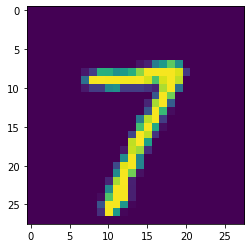

In [9]:
train_data_iter = iter(train_data_loader)
images, labels = train_data_iter.next()
outputs = cnn(images)

i=2
print("labels["+str(i)+"] =",labels[i], ", ラベルデータ")
print("outputs["+str(i)+"] =",outputs[i], ", モデルで予測したラベル選択確率")
print("torch.argmax(outputs["+str(i)+"]) =",torch.argmax(outputs[i]), ", 予測ラベル（モデルで予測したラベル選択確率が最大のラベル）")
print("images["+str(i)+"][0].numpy() =\n",images[i][0].numpy(), ", 輝度データをそのまま表示")
plt.imshow(images[i][0])
